In [337]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import json
import csv

### The following cells show the result of pose estimation based on different image resolution. 

Basically, the image resolutions are ranging from 80x80 to 496x496, all multiples of 16.

The result data is located in folder 'step1'

In [338]:
col_info = ['model', 'cocoyear', 'resolution', 'round', 'time_elapsed',
            'AP1', 'AP2', 'AP3', 'AP4', 'AP5', 'AR1', 'AR2', 'AR3', 'AR4', 'AR5']
df = pd.DataFrame(columns=col_info)

In [339]:
for i in range(6,32):
    res = i*16
    resolution = str(res)+'x'+str(res)
    filename = './step1/estimation_result_cmu_coco2017_%s.csv' % resolution

    with open(filename) as f:
        reader = csv.reader(f)
        round = 1
        for row in reader:
            precision_and_recall = row[0:10]
            time_elapsed = float(row[10])
            df = df.append(pd.Series(['cmu', 2017, res, round, time_elapsed,
                                      float(precision_and_recall[0]),
                                      float(precision_and_recall[1]),
                                      float(precision_and_recall[2]),
                                      float(precision_and_recall[3]),
                                      float(precision_and_recall[4]),
                                      float(precision_and_recall[5]),
                                      float(precision_and_recall[6]),
                                      float(precision_and_recall[7]),
                                      float(precision_and_recall[8]),
                                      float(precision_and_recall[9])], index=df.columns), ignore_index=True)
            round +=1

df

,model,cocoyear,resolution,round,time_elapsed,AP1,AP2,AP3,AP4,AP5,AR1,AR2,AR3,AR4,AR5
0,cmu,2017,96,1,155.992429,0.076224,0.171133,0.057660,0.002864,0.172485,0.098583,0.197733,0.089736,0.001912,0.230100
1,cmu,2017,96,2,157.988203,0.076224,0.171133,0.057660,0.002864,0.172485,0.098583,0.197733,0.089736,0.001912,0.230100
2,cmu,2017,96,3,151.602616,0.076224,0.171133,0.057660,0.002864,0.172485,0.098583,0.197733,0.089736,0.001912,0.230100
3,cmu,2017,96,4,155.027639,0.076224,0.171133,0.057660,0.002864,0.172485,0.098583,0.197733,0.089736,0.001912,0.230100
4,cmu,2017,96,5,158.488631,0.076224,0.171133,0.057660,0.002864,0.172485,0.098583,0.197733,0.089736,0.001912,0.230100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
255,cmu,2017,496,6,428.543510,0.441225,0.720170,0.449806,0.412471,0.479092,0.498945,0.740554,0.519364,0.421087,0.608956
256,cmu,2017,496,7,428.181316,0.441225,0.720170,0.449806,0.412471,0.479092,0.498945,0.740554,0.519364,0.421087,0.608956
257,cmu,2017,496,8,428.393865,0.441225,0.720170,0.449806,0.412471,0.479092,0.498945,0.740554,0.519364,0.421087,0.608956
258,cmu,2017,496,9,429.243396,0.441225,0.720170,0.449806,0.412471,0.479092,0.498945,0.740554,0.519364,0.421087,0.608956


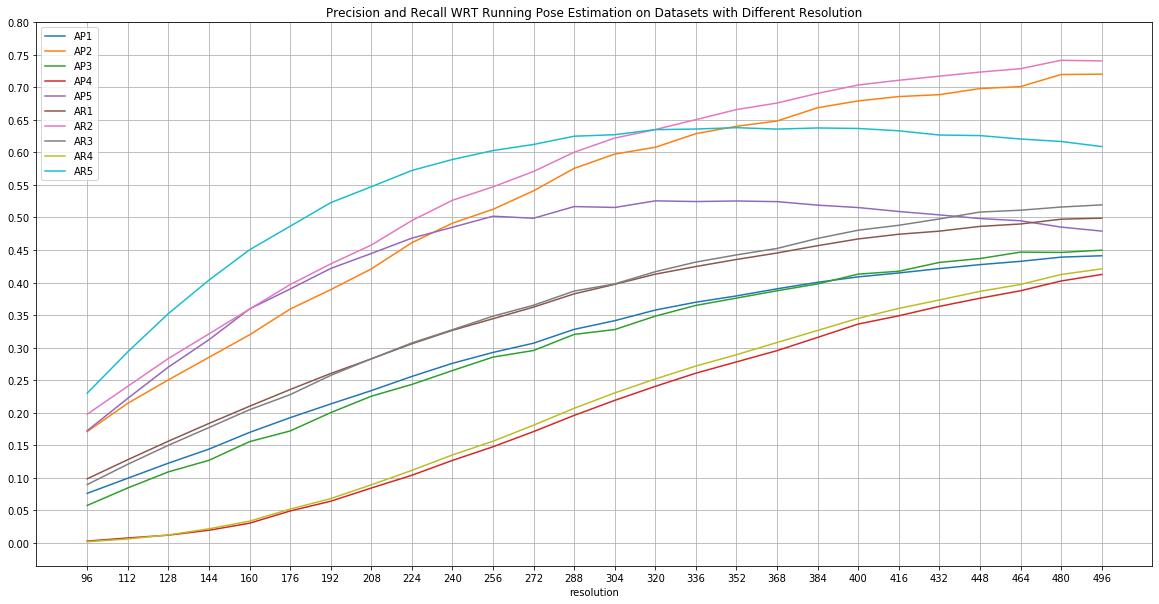

In [340]:
xticks = np.arange(96, 512, 16)
yticks = np.arange(0.0, 0.85, 0.05)
df_new = (df.loc[df['round']==1]).drop(columns=['time_elapsed', 'round', 'model', 'cocoyear'])
plot = df_new.plot(x='resolution', xticks=xticks, yticks = yticks, grid=True, figsize=(20,10), title='Precision and Recall WRT Running Pose Estimation on Datasets with Different Resolution')
fig = plot.get_figure()
fig.savefig('step1_precision_and_recall.png', dpi=200)

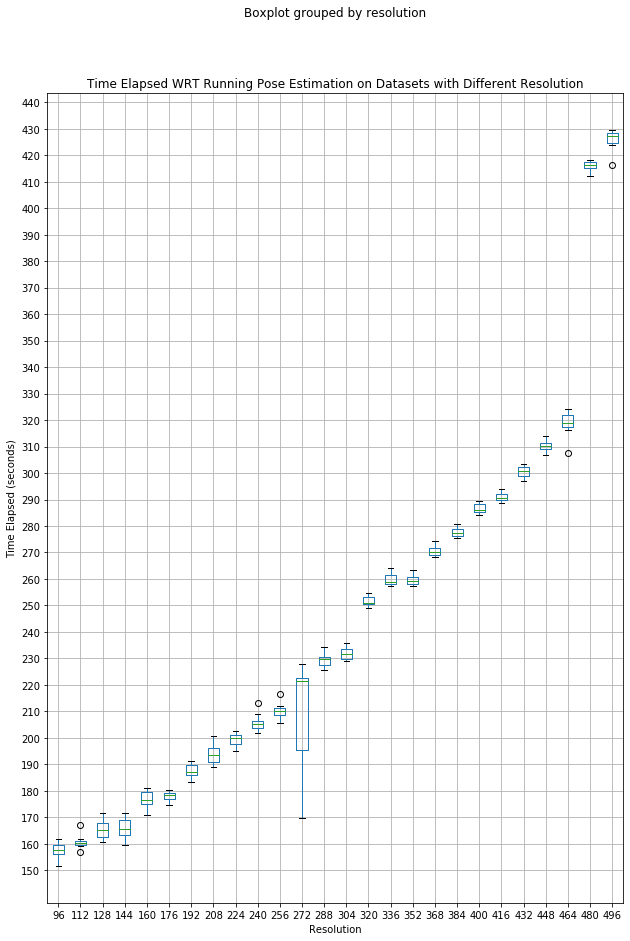

In [341]:
boxplot = df[['resolution','time_elapsed','round']].boxplot(by='resolution', figsize=(10,15))

boxplot.set_ylabel('Time Elapsed (seconds)')
boxplot.set_xlabel('Resolution')
boxplot.set_title('Time Elapsed WRT Running Pose Estimation on Datasets with Different Resolution')
yticks = np.arange(150, 450, 10)
boxplot.set_yticks(yticks)

fig = boxplot.get_figure()
fig.savefig('step1_time_elapsed.png', dpi=300)

### Next Step: Running face detection on the COCO Dataset.

The model has a parameter called `number_of_times_to_upsample` – It determines how many times to upsample the image looking for faces. Higher numbers find smaller faces. I can only run the model with maximum `number_of_times_to_upsample` of 2. If higher, it will report a "out of memory" error.

Since the upsample can only be 0, 1, or 2, I hardcoded the result in the following cell.

In [342]:
col_info_2 = ['face_detected', 'time_elapsed', 'upsample', 'round']
df_2 = pd.DataFrame(columns=col_info_2)

In [343]:
for i in range(0,3):
    filename = './step2/face_detection_time_report_upsample_%s.csv' % i

    with open(filename) as f:
        reader = csv.reader(f)
        round = 1
        for row in reader:
            face_detected = int(row[0])
            time_elapsed = float(row[1])
            df_2 = df_2.append(pd.Series([face_detected, time_elapsed, i, round], index=df_2.columns), ignore_index=True)
            round +=1

df_2

,face_detected,time_elapsed,upsample,round
0,537.0,27.375759,0.0,1.0
1,537.0,26.950835,0.0,2.0
2,537.0,26.959489,0.0,3.0
3,537.0,26.958896,0.0,4.0
4,537.0,26.950530,0.0,5.0
5,537.0,26.951022,0.0,6.0
6,537.0,26.954669,0.0,7.0
7,537.0,26.953110,0.0,8.0
8,537.0,26.946444,0.0,9.0
9,537.0,26.943110,0.0,10.0


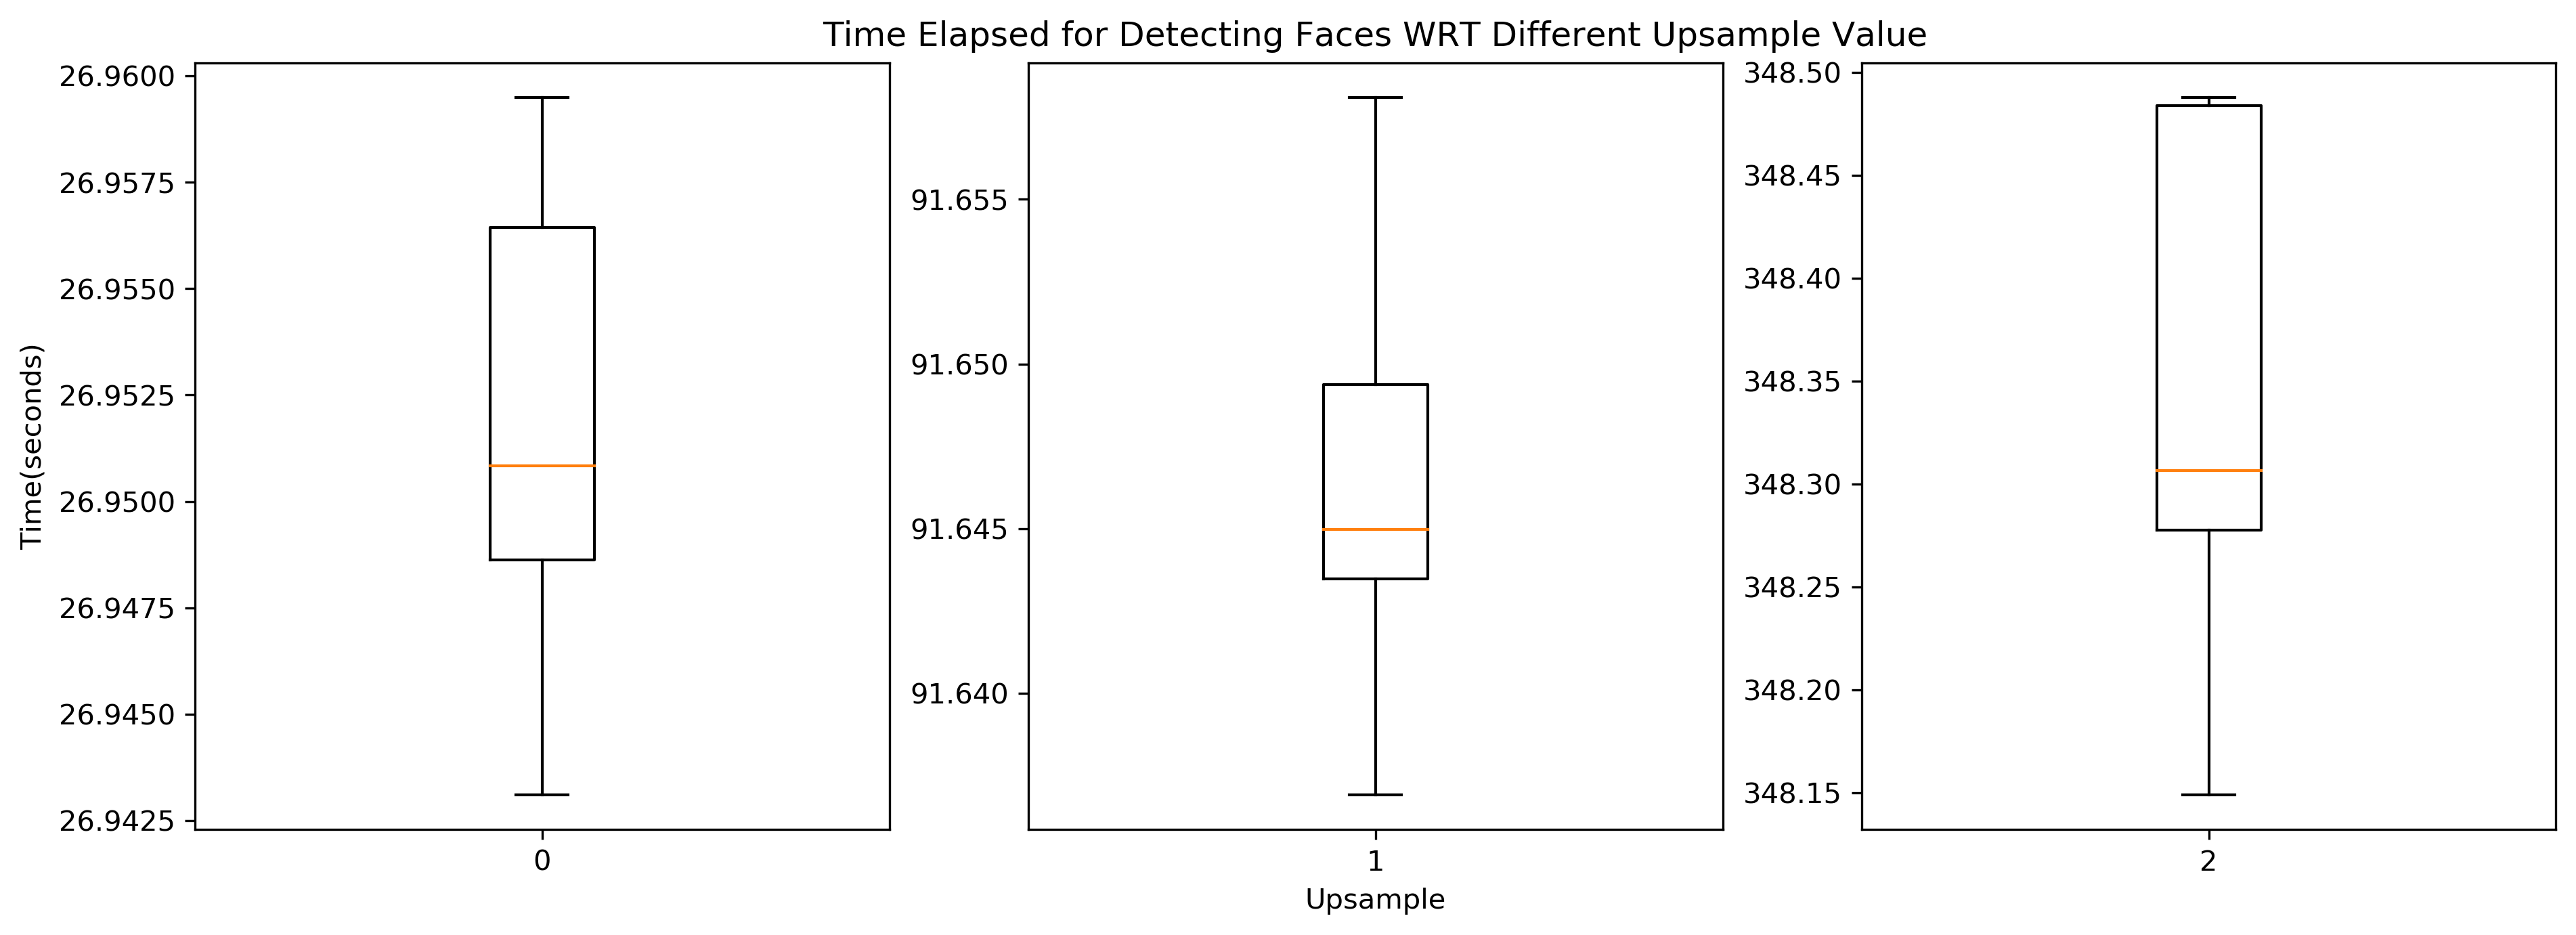

In [344]:
x = (0,1,2,3)
fig = plt.figure(figsize=[15,5],dpi=300)
ax1=plt.subplot(1, 3, 1)
ax1.boxplot(x = (df_2.loc[df_2['upsample']==0])[['time_elapsed']].values, showfliers=False, positions=[0,])
ax1.set_ylabel('Time(seconds)')
ax2=plt.subplot(1, 3, 2)
ax2.boxplot(x = (df_2.loc[df_2['upsample']==1])[['time_elapsed']].values, showfliers=False, positions=[1,])
ax2.set_title('Time Elapsed for Detecting Faces WRT Different Upsample Value')
ax2.set_xlabel('Upsample')
ax3=plt.subplot(1, 3, 3)
ax3.boxplot(x = (df_2.loc[df_2['upsample']==2])[['time_elapsed']].values, showfliers=False, positions=[2,])

plt.show()
fig.savefig('step2_time_elapsed.png', dpi=300)

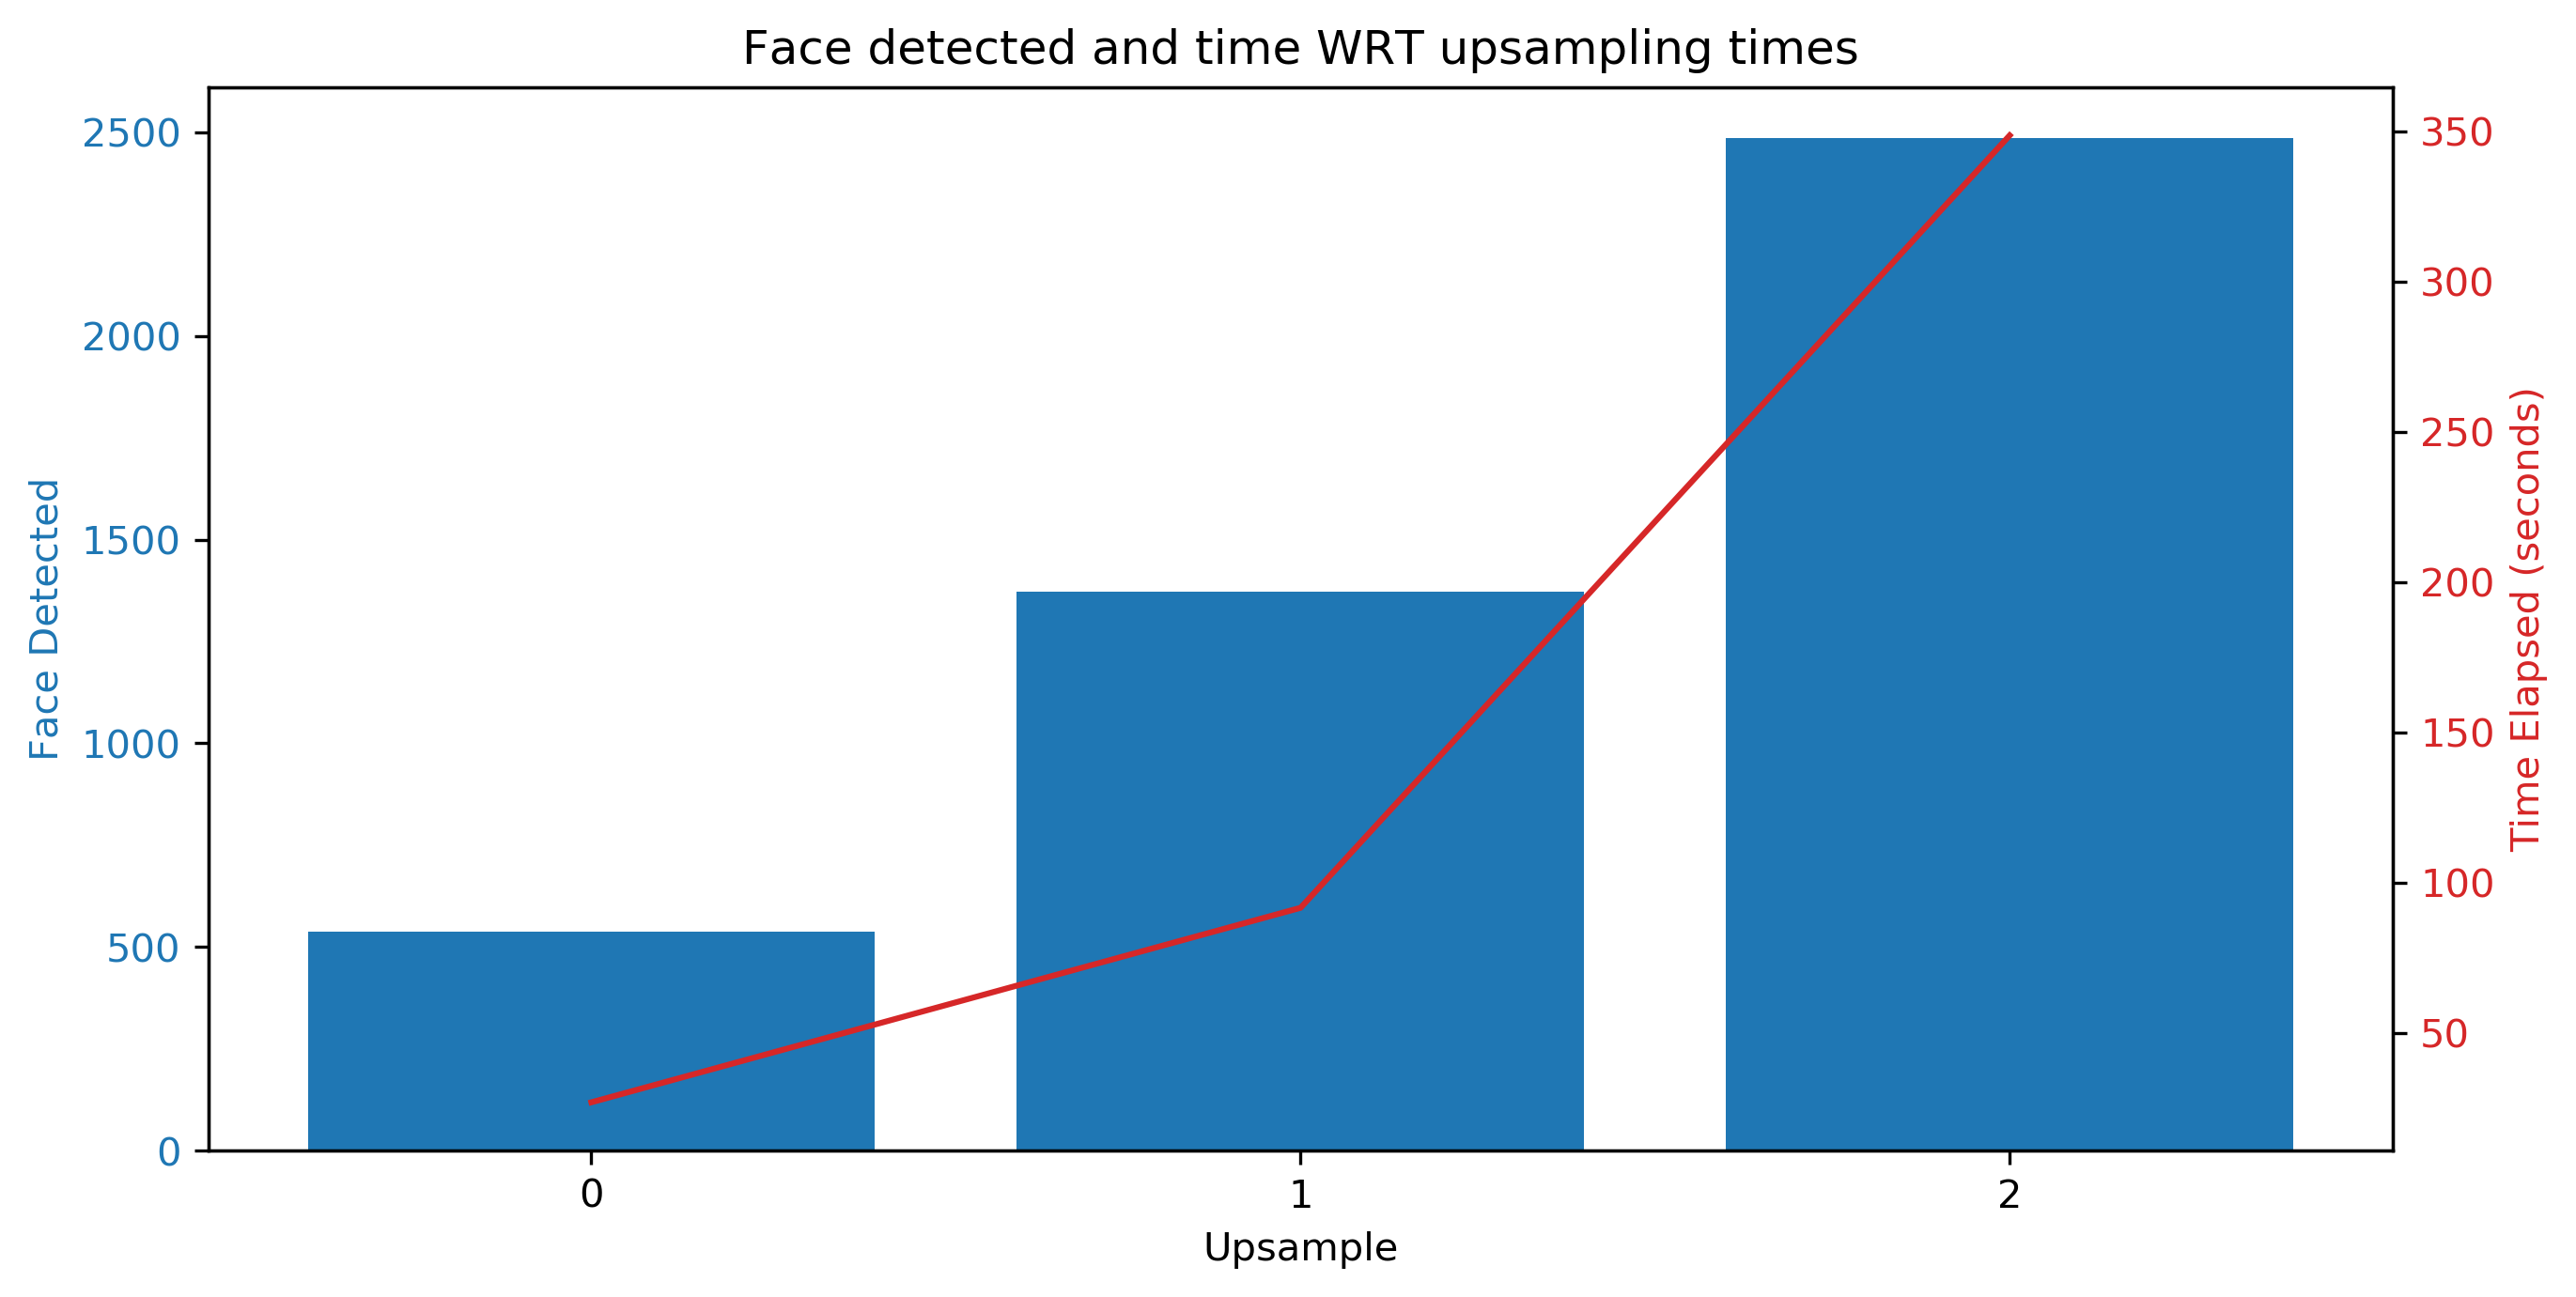

In [345]:
#Plotting the data
fig = plt.figure(figsize=[10,5],dpi=300)
ax1 = plt.subplot()
color = 'tab:blue'
ax1.set_title('Face detected and time WRT upsampling times')
ax1.set_xlabel('Upsample')
ax1.set_ylabel('Face Detected', color=color)
ax1.bar(df_2['upsample'], df_2['face_detected'], color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Time Elapsed (seconds)', color=color)
ax2.plot((df_2.loc[df_2['round']==1])['upsample'], 
         (df_2.groupby('upsample', as_index=False)['time_elapsed'].mean())['time_elapsed'], color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_xticks((0,1,2))
plt.show()
fig.savefig('step2_face_detected.png', dpi=300)

### Next Step: Blur the faces in the dataset using Gaussian Blur. Then run pose estimation again on blurred dataset.

The Gaussian Blur algorithm has a parameter called `radius`, the higher the value, the more the image is blurred

The following cells show the result of pose estimation on datasets that are blurred with different `radius` value(ranging from 1 to 15).

The pose estimation model used here is cmu model, with resolution of 432x368, which is the default resolution.

The result data is located in folder 'step3'

In [346]:
col_info_3 = ['blur_radius', 'round', 'time_elapsed', 'AP1', 'AP2', 'AP3', 'AP4', 'AP5', 'AR1', 'AR2', 'AR3', 'AR4', 'AR5']
df_3 = pd.DataFrame(columns=col_info_3)
for i in range(1,21):
    filename = './step3/estimation_result_432x368_2_%s.csv' % i
    with open(filename) as f:
        reader = csv.reader(f)
        round = 1
        for row in reader:
            precision_and_recall = row[0:10]
            time_elapsed = float(row[10])
            df_3 = df_3.append(pd.Series([i, round, time_elapsed,
                                      float(precision_and_recall[0]),
                                      float(precision_and_recall[1]),
                                      float(precision_and_recall[2]),
                                      float(precision_and_recall[3]),
                                      float(precision_and_recall[4]),
                                      float(precision_and_recall[5]),
                                      float(precision_and_recall[6]),
                                      float(precision_and_recall[7]),
                                      float(precision_and_recall[8]),
                                      float(precision_and_recall[9])], index=df_3.columns), ignore_index=True)
            round +=1

df_3

,blur_radius,round,time_elapsed,AP1,AP2,AP3,AP4,AP5,AR1,AR2,AR3,AR4,AR5
0,1.0,1.0,277.911038,0.417272,0.680644,0.427407,0.338475,0.532268,0.471363,0.702613,0.488035,0.347528,0.644036
1,1.0,2.0,276.709753,0.417272,0.680644,0.427407,0.338475,0.532268,0.471363,0.702613,0.488035,0.347528,0.644036
2,1.0,3.0,276.337232,0.417272,0.680644,0.427407,0.338475,0.532268,0.471363,0.702613,0.488035,0.347528,0.644036
3,1.0,4.0,278.871592,0.417272,0.680644,0.427407,0.338475,0.532268,0.471363,0.702613,0.488035,0.347528,0.644036
4,1.0,5.0,275.507458,0.417272,0.680644,0.427407,0.338475,0.532268,0.471363,0.702613,0.488035,0.347528,0.644036
...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,20.0,6.0,274.494107,0.320904,0.603711,0.301002,0.285943,0.365431,0.376023,0.632872,0.372953,0.295630,0.487105
196,20.0,7.0,273.748701,0.320904,0.603711,0.301002,0.285943,0.365431,0.376023,0.632872,0.372953,0.295630,0.487105
197,20.0,8.0,273.390772,0.320904,0.603711,0.301002,0.285943,0.365431,0.376023,0.632872,0.372953,0.295630,0.487105
198,20.0,9.0,274.872612,0.320904,0.603711,0.301002,0.285943,0.365431,0.376023,0.632872,0.372953,0.295630,0.487105


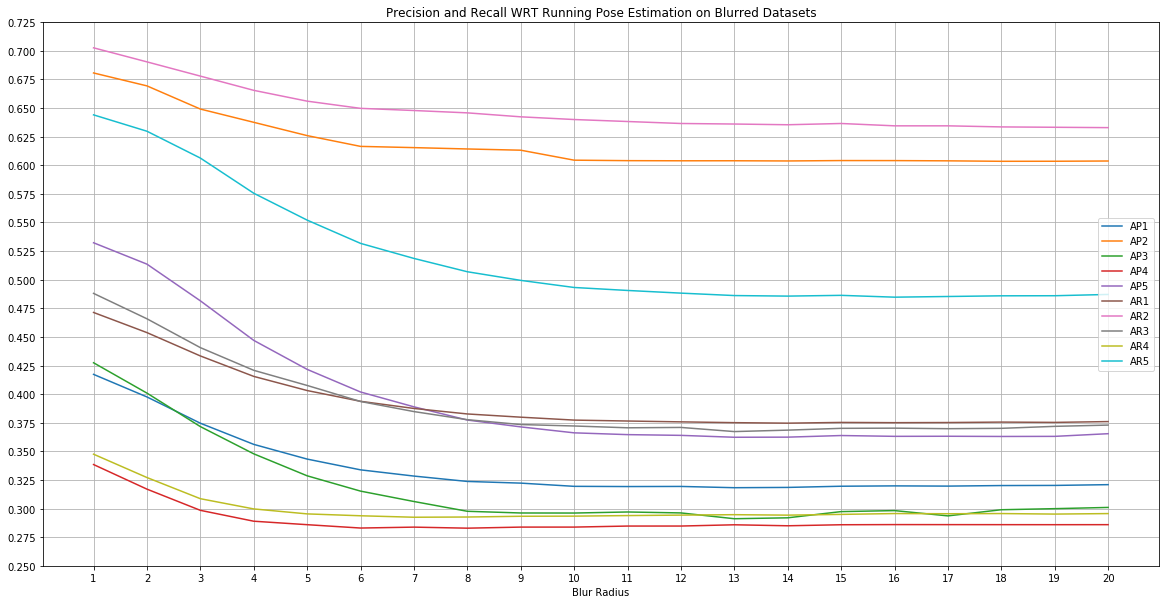

In [347]:
xticks = np.arange(1, 21, 1)
yticks = np.arange(0.25, 0.75, 0.025)
df_new = (df_3.loc[df_3['round']==1]).drop(columns=['time_elapsed', 'round'])
plot = df_new.plot(x='blur_radius', xticks=xticks, yticks=yticks, grid=True, figsize=(20,10),
                   title='Precision and Recall WRT Running Pose Estimation on Blurred Datasets')
plot.set_xlabel('Blur Radius')
fig = plot.get_figure()
fig.savefig('step3_precision_and_recall_wrt_blur_radius.png', dpi=300)

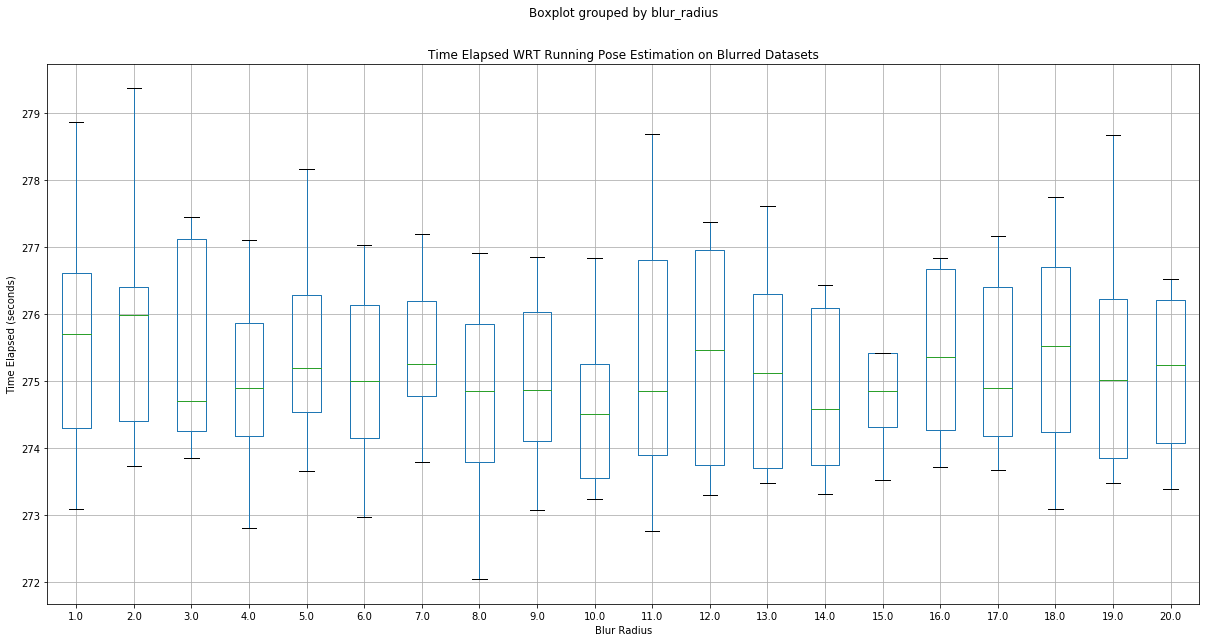

In [348]:
boxplot = df_3[['blur_radius','time_elapsed','round']].boxplot(column='time_elapsed', 
                                                               by='blur_radius', figsize=(20,10), showfliers=False)
boxplot.set_ylabel('Time Elapsed (seconds)')
boxplot.set_xlabel('Blur Radius')
boxplot.set_title('Time Elapsed WRT Running Pose Estimation on Blurred Datasets')


fig = boxplot.get_figure()
fig.savefig('step3_time_elapsed.png', dpi=300)

### Next Step: Run face detection model on blurred datasets

After the datasets being blurred with different `radius`, run the face detection model again to see how many faces it still can detect.

The face detection model uses value of 2 on `number_of_times_to_upsample`.

`radius`: ranging from 1 to 15

The result data is located in folder 'step4'

In [349]:
col_info_3 = ['radius', 'time_elapsed', 'face_detected']
df3 = pd.DataFrame(columns=col_info_3)
for i in range(1,16):
    filename = './step4/time_report_upsample_2_radius_%s.json' % str(i)
    with open(filename) as f:
        data = f.readline()
        data = data.split('.\\n')

        time_elapsed = float((data[0].split())[-1])
        face_detected = float(data[1].split('"')[0].split()[-1])
        
        df3 = df3.append(pd.Series([i, time_elapsed, face_detected], index=df3.columns), ignore_index=True)

df3

,radius,time_elapsed,face_detected
0,1.0,347.115346,1788.0
1,2.0,345.804269,1043.0
2,3.0,347.274081,689.0
3,4.0,346.802418,465.0
4,5.0,346.321708,328.0
5,6.0,347.754167,228.0
6,7.0,348.488556,172.0
7,8.0,346.481029,137.0
8,9.0,366.334584,112.0
9,10.0,360.487055,84.0


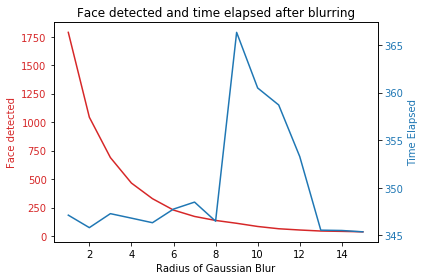

<Figure size 6000x2000 with 0 Axes>

The unit of 'Time elapsed' is second.


In [350]:
fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.set_title('Face detected and time elapsed after blurring')
ax1.set_xlabel('Radius of Gaussian Blur')
ax1.set_ylabel('Face detected', color=color)
ax1.plot(df3['radius'], df3['face_detected'], color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Time Elapsed', color=color)
ax2.plot(df3['radius'], df3['time_elapsed'], color=color)
ax2.tick_params(axis='y', labelcolor=color)
fig.tight_layout()
plt.figure(figsize=[30,10],dpi=200)
plt.show()

print('The unit of \'Time elapsed\' is second.')